In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
rng = np.random.default_rng()
import torch
from torch import nn
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

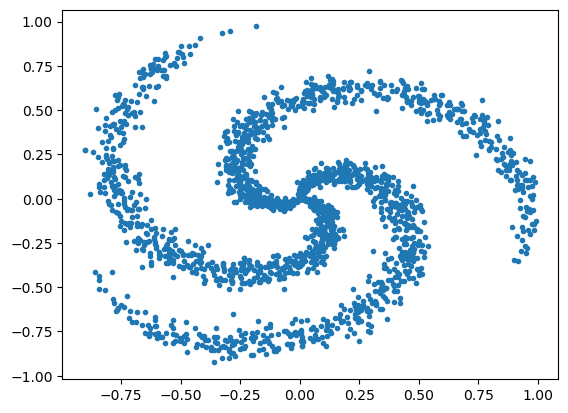

In [3]:
def generate_pinwheel(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb
    D = 2 # dimensionality
    K = 3 # number of classes
    N = num // K  # note: we will not generate exactly num datapoints unless K divides num
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + rng.standard_normal(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    return X
X = generate_pinwheel(num=2000, rng=rng)
plt.plot(X[:, 0], X[:, 1], '.')
spi=X

In [4]:
spi.shape

(1998, 2)

In [5]:
tensor_data = torch.tensor(spi, dtype=torch.float32)
data_loader = DataLoader(TensorDataset(tensor_data), batch_size=25, shuffle=True)

device = torch.device("mps")
device

device(type='mps')

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
epochs = 2000
epoch_losses = []
d_losses = []
g_losses = []
generator = Generator(300, 2).to(device)
discriminator = Discriminator(2).to(device)


g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)

In [7]:
for epoch in range(epochs):
    for real_data in data_loader:
        real_data = real_data[0].to(device)


        z = torch.randn(real_data.size(0), 300, device=device)
        fake_data = generator(z)


        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data.detach())
        d_loss = -torch.mean(torch.log(d_real) + torch.log(1 - d_fake))


        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        g_fake = discriminator(fake_data)
        g_loss = -torch.mean(torch.log(g_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 100 == 0:
        epoch_losses.append(epoch + 1)
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        print(f'Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch 100/2000, D Loss: 1.4106, G Loss: 0.6637
Epoch 200/2000, D Loss: 1.4252, G Loss: 0.6447
Epoch 300/2000, D Loss: 1.3056, G Loss: 0.7261
Epoch 400/2000, D Loss: 1.3805, G Loss: 0.7619
Epoch 500/2000, D Loss: 1.3889, G Loss: 0.7067
Epoch 600/2000, D Loss: 1.3732, G Loss: 0.7276
Epoch 700/2000, D Loss: 1.3672, G Loss: 0.6777
Epoch 800/2000, D Loss: 1.5203, G Loss: 0.7087
Epoch 900/2000, D Loss: 1.3182, G Loss: 0.6589
Epoch 1000/2000, D Loss: 1.3234, G Loss: 0.7143
Epoch 1100/2000, D Loss: 1.3859, G Loss: 0.7012
Epoch 1200/2000, D Loss: 1.4312, G Loss: 0.7173
Epoch 1300/2000, D Loss: 1.4390, G Loss: 0.6990
Epoch 1400/2000, D Loss: 1.4006, G Loss: 0.7035
Epoch 1500/2000, D Loss: 1.3879, G Loss: 0.7047
Epoch 1600/2000, D Loss: 1.3801, G Loss: 0.7050
Epoch 1700/2000, D Loss: 1.3755, G Loss: 0.6799
Epoch 1800/2000, D Loss: 1.3905, G Loss: 0.7083
Epoch 1900/2000, D Loss: 1.3966, G Loss: 0.7157
Epoch 2000/2000, D Loss: 1.3956, G Loss: 0.6911


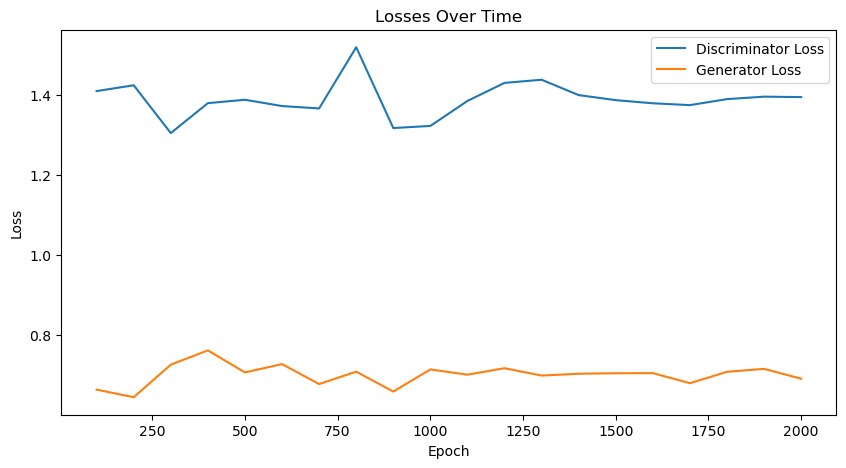

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, d_losses, label='Discriminator Loss')
plt.plot(epoch_losses, g_losses, label='Generator Loss')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

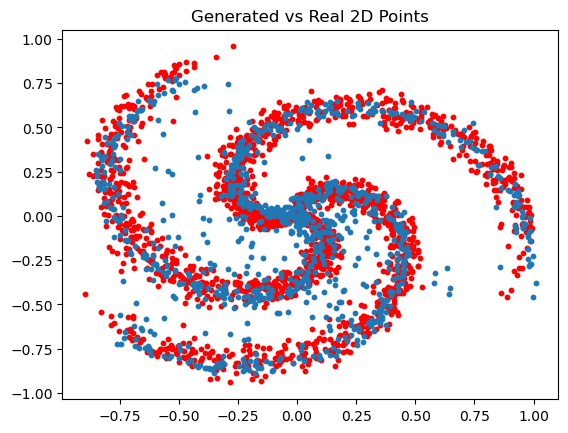

In [12]:
z = torch.randn(1000, 300, device=device)
generated_points = generator(z).detach().cpu().numpy()
plt.scatter(spi[:, 0], spi[:, 1], s=10, c='red')  
plt.scatter(generated_points[:, 0], generated_points[:, 1], s=10)
plt.title('Generated vs Real 2D Points')
plt.show()

In [10]:
torch.save(generator, 'GAN_pin_gen.pth')
torch.save(Discriminator, 'GAN_pin_disc.pth')

In [7]:
model = torch.load('GAN_spi_gen.pth')
model.eval()

Generator(
  (net): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [8]:
z = torch.randn(1000, 300, device=torch.device("mps"))
generated_points = model(z).detach().cpu().numpy()
np.save("GAN_pin.npy",generated_points)